# Continuum Suppression
Continuum is the name given to events with the proces $e^+ e^- \rightarrow qq$ (i.e. the electron-positron collisions lead to some lighter hadrons without creating a $\Upsilon (4S)$ resonance (which is what we used in the other examples.

These events can be distinguished by looking at the shape of the momentum distribution, as lighter mesons (than BBbar) have more momentuum, so its distribution looks narrower in contrast with the Upsilon(4S) resonance where most of the energy goes to the mass and, with lower momentum available, its distribution must be uniform

<img src="./continuum_with_labels.png">

To reconstruct the event shape, we will reconstruct B candidates and then reconstruct its Rest of Event (ROE). For this, we will use two samples:

1. one with uubar continuum background
2. one with $B \rightarrow K_S^0 \pi^0$ decays

So, first, we need to import them

In [1]:
import basf2 as b2
import modularAnalysis as ma
import stdPi0s

In [2]:
# Create a path with the samples as input
main = b2.create_path()

ma.inputMdstList(
    environmentType="default",
    filelist=[
        b2.find_file("starterkit/2021/B02ks0pi0_sample.root",
                     data_type="examples"),
        b2.find_file("starterkit/2021/uubar_sample.root",
                     data_type="examples"),
    ],
    path=main,
)

Now, we will reconstruct the Kshort candidates from the two charged pions

In [8]:
# Reconstruct neutral pions
stdPi0s.stdPi0s(path=main, listtype="eff60_Jan2020")

# Now, to reconstruct the Ks, first we reconstruct
# charged pions with the given cut
ma.fillParticleList(
    decayString="pi+:good", cut="chiProb > 0.001 and pionID > 0.5", path=main
)

# Now, we can combine them to reconstruct the K_S0
# We will consider this cut as we only want to combine pions whose
# combined invariant mass is within 36MeV of the K0 mass
ma.reconstructDecay(
    decayString="K_S0 -> pi+:good pi-:good", cut="0.480<=M<=0.516", path=main
)

# Now, we can combine the pi0 and K_S0 that we reconstructed to
# look for the B0 candidates
ma.reconstructDecay(
    decayString="B0  -> K_S0 pi0:eff60_Jan2020",
    cut="5.1 < Mbc < 5.3 and abs(deltaE) < 2",
    path=main,
)

[WARNING] stdPi0s is loading "Jan2020" pi0 recommendations. Please check Neutrals Performance Confluence page for most up-to-date pi0 recommendations.


Now, we will create the ROE of the B0 candidates and append common cuts for continuum suppression

In [9]:
ma.buildRestOfEvent(target_list_name="B0", path=main)
cleanMask = (
    "cleanMask",
    "nCDCHits > 0 and useCMSFrame(p)<=3.2",
    "p >= 0.05 and useCMSFrame(p)<=3.2",
)
ma.appendROEMasks(list_name="B0", mask_tuples=[cleanMask], path=main)

ma.buildContinuumSuppression(list_name="B0", roe_mask="cleanMask", path=main)

Now, we will add some continuum variables to evaluate the performance of our method along with the truth-variable `isContinuumEvent` to do benchmarking

In [10]:
simpleCSVariables = [
    "R2",
    "thrustBm",
    "thrustOm",
    "cosTBTO",
    "cosTBz",
]

ma.variablesToNtuple(
    decayString="B0",
    variables=simpleCSVariables + ["Mbc", "isContinuumEvent"],
    filename="ContinuumSuppression.root",
    treename="tree",
    path=main,
)

Let's rock n' roll!

In [11]:
b2.process(main)

Welcome to JupyROOT 6.20/04


Now, we can plot the distribution of some useful variables to determine the shape of the event. We will use a popular choice called the ratio of the second and zeroth Fox-Wolfram moment `R2`

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt
from root_pandas import read_root

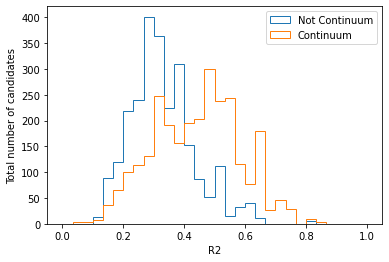

In [13]:
df = read_root('ContinuumSuppression.root')

fig, ax = plt.subplots()

signal_df = df.query('(isContinuumEvent == 0.0)')
continuum_df = df.query('(isContinuumEvent == 1.0)')

n, bins, patches = ax.hist(signal_df['R2'], bins=30, range=(0, 1), label='Not Continuum', histtype='step')
n, bins, patches = ax.hist(continuum_df['R2'], bins=30, range=(0, 1), label='Continuum', histtype='step')
ax.set_xlabel('R2')
ax.set_ylabel('Total number of candidates')
ax.legend()